In [13]:
import torchvision
import torchvision.transforms as transforms

import os
import sys
import time
import math
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from torch.nn import Parameter
from models.model_utils import get_all_params
from wrapper import ModelWrapper
from art.attacks.evasion import FastGradientMethod, CarliniL2Method, CarliniLInfMethod
from art.estimators.classification import PyTorchClassifier
import matplotlib.pyplot as plt

In [5]:
batch = 64
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor()])
transform_test = transforms.Compose([transforms.RandomCrop(32, padding=4),transforms.ToTensor()])
test_train = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch)

In [6]:
checkpoint = torch.load('./checkpoint/MNIST/excessive.t7')
start_epoch = checkpoint['epoch']
model = checkpoint['model']
model.eval()
model = ModelWrapper(model)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
estimator = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 32, 32),
    nb_classes=10,
)

In [15]:
attack = FastGradientMethod(estimator=estimator, eps=32/255)
objective, adv_objective, total = 0., 0., 0.
endurance = 0.
for i, (data, targets) in enumerate(testloader):
    print(i)
    out, out_bij, out_nui, sldj = model(data, ori=True)
    targets = targets.to(out.device)
    _, predicted = torch.max(out.data, 1)
    objective += predicted.eq(targets.data).sum().item()
    total += targets.size(0)
    if i == 0:
        adv_out, adv_out_bij, adv_out_nui, adv_sldj = out, out_bij, out_nui, sldj
        adv_data = data
    if i > 0:
        break
objective = float(objective) / float(total)
print(objective)
adv_objective = float(adv_objective) / float(total)
print(adv_objective)
print(endurance/10000)

0
1
0.921875
0.0
0.0


In [16]:
# u, w'
adv_data_1 = model.model.module.inverse(out_bij, adv_out_nui, adv_sldj)
adv_out_1 = model(adv_data_1)
# u', w
adv_data_2 = model.model.module.inverse(adv_out_bij, out_nui, sldj)
adv_out_2 = model(adv_data_2)

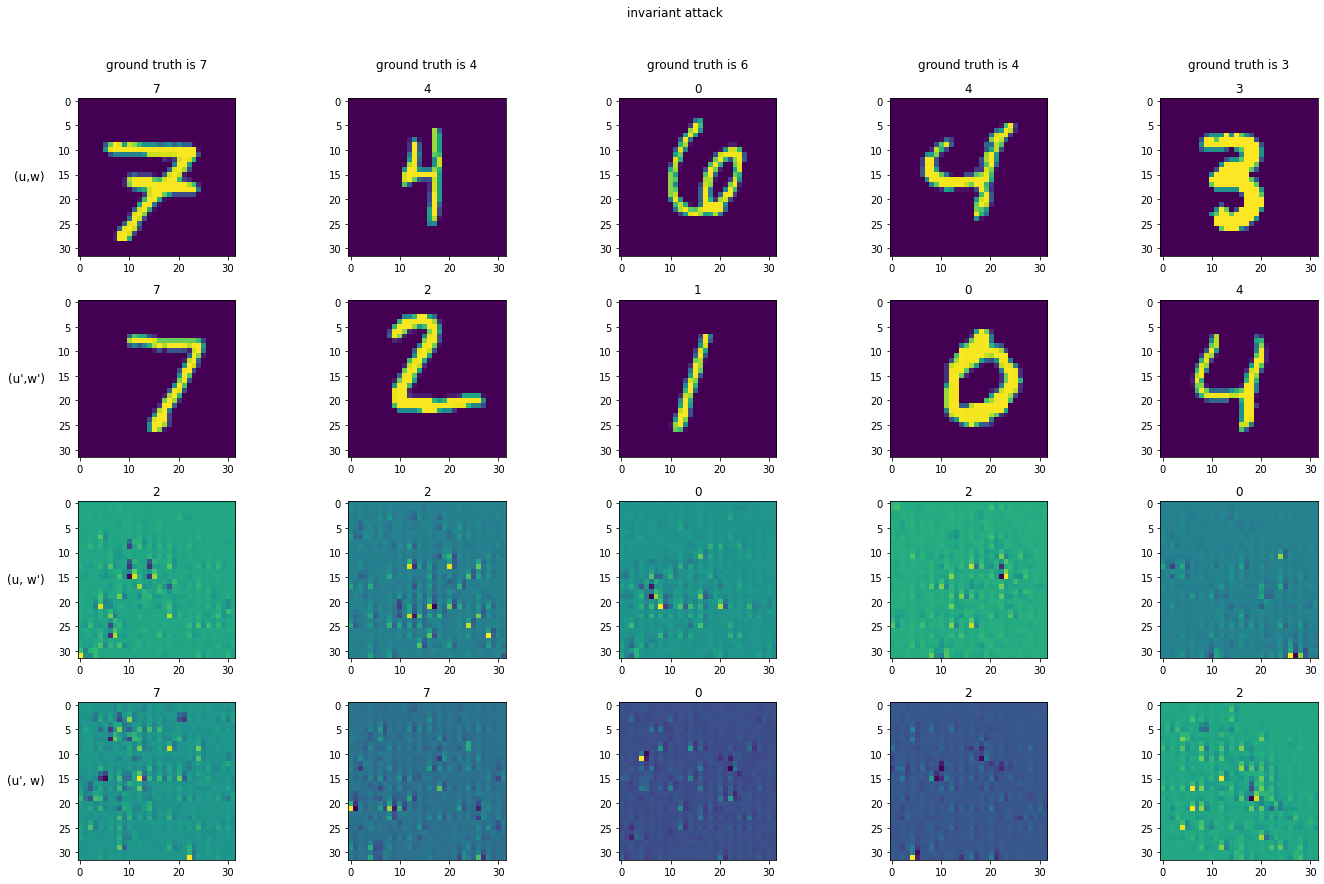

In [18]:
label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cols = []
for i in range(5):
    cols.append("ground truth is {}".format(label[targets[i]]))
rows = ['(u,w)', '(u\',w\')', '(u, w\')', '(u\', w)']

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
fig.suptitle('invariant attack', y=1.02)


for i in range(5):
    axes[0,i].imshow(data.to('cpu')[i].permute(1,2,0))
    axes[0,i].title.set_text(label[torch.argmax(out[i])])

    axes[1,i].imshow(adv_data.to('cpu')[i].permute(1,2,0))
    axes[1,i].title.set_text(label[torch.argmax(adv_out[i])])

    axes[2,i].imshow(adv_data_1.to('cpu').detach()[i].permute(1,2,0))
    axes[2,i].title.set_text(label[torch.argmax(adv_out_1[i])])

    axes[3,i].imshow(adv_data_2.to('cpu').detach()[i].permute(1,2,0))
    axes[3,i].title.set_text(label[torch.argmax(adv_out_2[i])])
row_pad = 5 # in points
col_pad = 30

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, col_pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
fig.tight_layout()
plt.show()